# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os


2024-03-11 20:53:58.177797: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 20:53:58.255079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 20:53:58.255131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 20:53:58.268472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 20:53:58.290852: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

/home/big/Kevin/Workspace/Homework/ecec147/project/Deep-Learning-EEG-BCI-Signal-Processing/EEG-Data


(2115, 22, 1000)


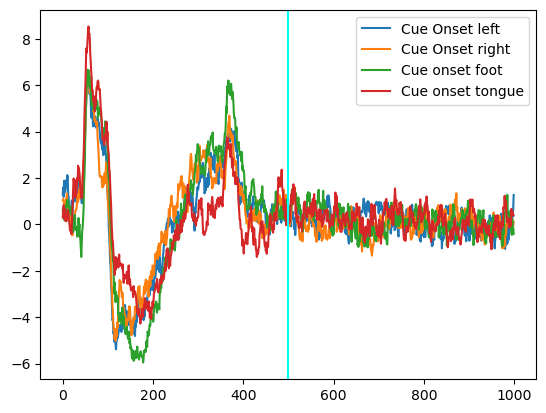

In [3]:
## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






# Data Preprocessing

In [4]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_valid_prep = test_data_prep(x_valid)
x_train, y_train = train_data_prep(x_train, y_train, 2,2,True)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid_prep.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid_prep.reshape(x_valid_prep.shape[0], x_valid_prep.shape[1], x_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (250, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (250, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (250, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460,

# CNN Model Architecture

In [5]:
from EEG_CNN import CNN

In [6]:
import itertools
# Building the CNN model using sequential class
mp = {'max pool' : True}
reg = {'reg 1e-3': 1e-3}
convdrop = {'conv drop': True}
filters = {'5x1 filter': 5}
convdepth = {'10 convlayers': 10}

models_names = []
models = []
for a in itertools.product(mp.items(), reg.items(), convdrop.items(), filters.items(), convdepth.items()):
    models_names.append([i[0] for i in a])
    models.append(CNN(input_shape=(400,1,22), use_max_pool=a[0][1], reg=a[1][1], dropout_on_conv=a[2][1], 
                      filters=[a[3][1] for _ in range(a[4][1])],
                      num_filters=[min(200, 25 * (2 ** i)) for i in range(a[4][1])]))

# Printing the model summary
# basic_cnn_model.summary()


2024-03-11 20:54:03.281120: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 20:54:03.342193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 20:54:03.342485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Train CNN Model

In [7]:
# Model parameter
# learning_rate = keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps)
learning_rate = 3e-3

epochs = 500
# cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [8]:
# Compiling the model
from keras.callbacks import ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
for model in models:
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
histories = []
for model in models:
# Training and validating the model
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8,
                              patience=20, min_lr=3e-5)
    histories.append(model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[reduce_lr],
             verbose=True)
    )



Epoch 1/500


2024-03-11 20:54:05.463094: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-11 20:54:05.759126: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-03-11 20:54:07.141707: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d5fd8c6d210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-11 20:54:07.141730: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-11 20:54:07.151756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710215647.249053    4679 device_compiler.h:186] Compiled clust

117/117 [==============================] - 10s 32ms/step - loss: 2.8087 - accuracy: 0.2492 - val_loss: 2.4207 - val_accuracy: 0.2360 - lr: 0.0030
Epoch 2/500
117/117 [==============================] - 2s 16ms/step - loss: 2.4608 - accuracy: 0.2685 - val_loss: 2.3815 - val_accuracy: 0.2680 - lr: 0.0030
Epoch 3/500
117/117 [==============================] - 2s 17ms/step - loss: 2.3741 - accuracy: 0.2689 - val_loss: 2.3342 - val_accuracy: 0.2280 - lr: 0.0030
Epoch 4/500
117/117 [==============================] - 2s 16ms/step - loss: 2.2972 - accuracy: 0.2685 - val_loss: 2.3336 - val_accuracy: 0.2280 - lr: 0.0030
Epoch 5/500
117/117 [==============================] - 2s 16ms/step - loss: 2.2152 - accuracy: 0.2780 - val_loss: 2.1737 - val_accuracy: 0.2160 - lr: 0.0030
Epoch 6/500
117/117 [==============================] - 2s 17ms/step - loss: 2.1332 - accuracy: 0.2814 - val_loss: 2.1096 - val_accuracy: 0.2080 - lr: 0.0030
Epoch 7/500
117/117 [==============================] - 2s 17ms/step -

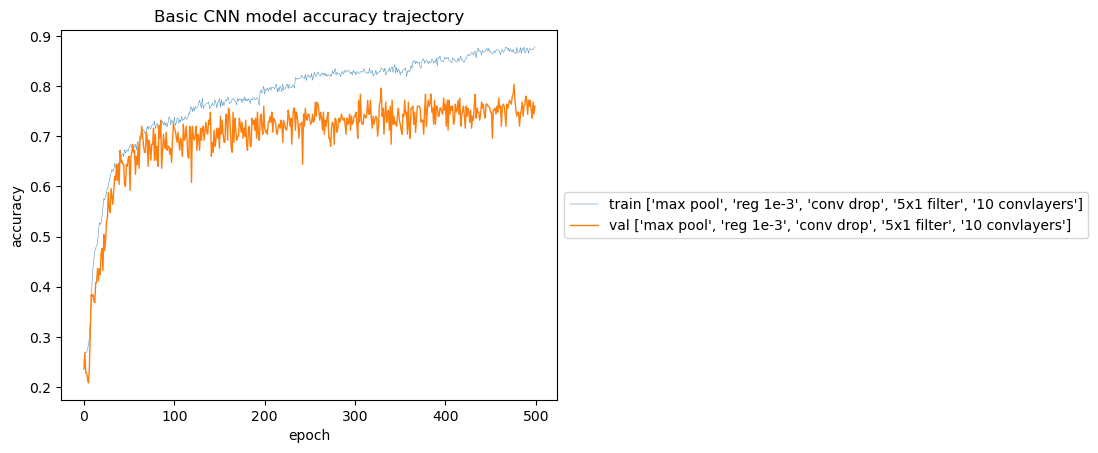

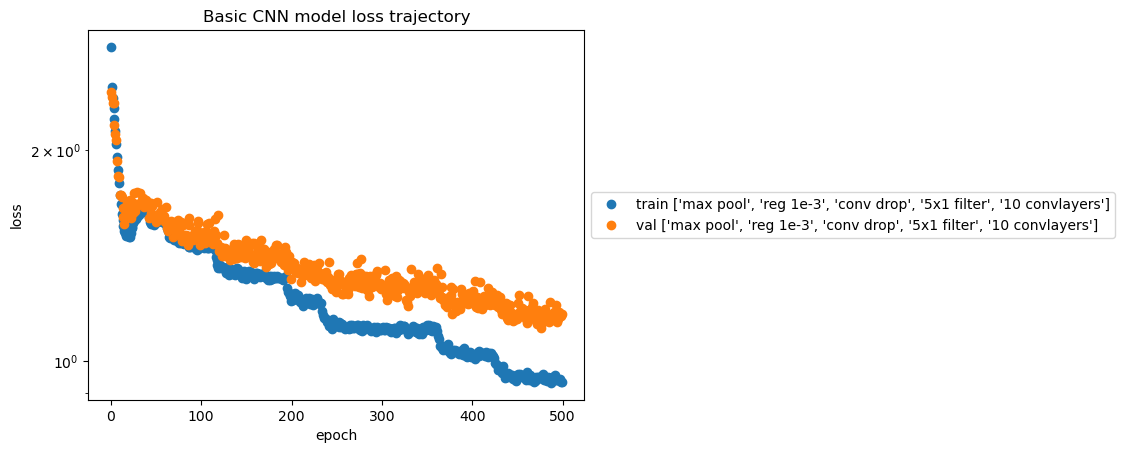

In [9]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
for hist in histories:
    plt.plot(hist.history['accuracy'], linewidth=0.3)
    plt.plot(hist.history['val_accuracy'], linewidth=1)
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
labels = []
for name in models_names:
    labels.append(f'train {name}')
    labels.append(f'val {name}')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
for hist in histories:
    plt.plot(hist.history['loss'],'o')
    plt.plot(hist.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
## Testing the basic CNN model

for model, name in zip(models, models_names):
    cnn_score = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test accuracy of {name}:',cnn_score[1])

Test accuracy of ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '10 convlayers']: 0.7516930103302002


In [16]:
from keras.models import save_model
from keras.utils import plot_model

# Save entire model
model_filename = f'../Models/CNN_deep_model{cnn_score[1]}.h5'
model.save(model_filename)

# Save weights only
weights_filename = f'../Models/CNN_deep_weights{cnn_score[1]}.h5'
model.save_weights(weights_filename)
# Load weights into a new model with the same architecture
# loaded_model = create_resnet_lstm_model() # create using resnet-15 architecture
# loaded_model.load_weights(weights_filename)

/home/big/miniforge3/envs/c147/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
maxes_ = []
finals_ = []
for model, name in zip(histories, models_names):
    maxes_.append(max(model.history['val_accuracy']))
    finals_.append(model.history['val_accuracy'][-1])
    print(f"Validation accuracy {name}: max: {max(model.history['val_accuracy'])}, final: {model.history['val_accuracy'][-1]}")
for pair in sorted(zip(finals_, models_names), key=lambda i: i[0], reverse=True):
    print(pair)

Validation accuracy ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '10 convlayers']: max: 0.8040000200271606, final: 0.7599999904632568
(0.7599999904632568, ['max pool', 'reg 1e-3', 'conv drop', '5x1 filter', '10 convlayers'])


In [13]:
color = ['r', 'b', 'g', 'o', 'y']
for param in [mp.items(), reg.items(), convdrop.items(), filters.items(), convdepth.items()]:
    if len(param) == 1:
        continue
    for i, param_name in enumerate(param):
        for name, label, history in zip(models_names, labels[1::2], histories):
            if param_name[0] in name:
                plt.plot(history.history['val_accuracy'], linewidth=1, color=color[i], label=label)
    plt.title('Basic CNN model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()